In [2]:
import sys
sys.path.append('../')
sys.path.append('../wildlife-tools-main')

In [3]:
DATA = 'data/BirdIndividualID_small'

In [4]:
from ultralytics import YOLO
import random
import cv2
from PIL import Image
import numpy as np

import matplotlib as plt
import pandas as pd


# Dataset loading tools

In [5]:
import pycocotools.mask as mask_coco
import cv2
import os
import numpy as np
import pandas as pd
from PIL import Image
import json

from wildlife_tools.data.dataset import WildlifeDataset
from torchvision.transforms import Resize


## 1. Create WildlifeDataset
- Use metadata dataframe

0


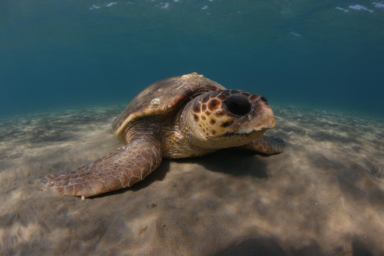

In [6]:
metadata = pd.read_csv('../wildlife-tools-main/examples/ExampleDataset/metadata.csv') # 3 images from SeaTurtleID
dataset_root = '../wildlife-tools-main/examples/ExampleDataset'

dataset = WildlifeDataset(metadata, dataset_root, transform=Resize(256))
img, label = dataset[0]
print(label)
img


0: 192x256 1 bear, 1458.1ms
Speed: 27.1ms preprocess, 1458.1ms inference, 10.1ms postprocess per image at shape (1, 3, 192, 256)


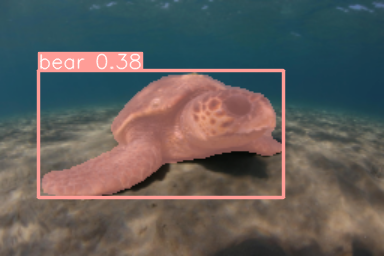

In [7]:
# Test the prediction
model = YOLO('content/yolov8x-seg.pt')

result_predict = model.predict(source = img, imgsz=(256), single_cls=True)

# show results
plot = result_predict[0].plot()
plot = cv2.cvtColor(plot, cv2.COLOR_BGR2RGB)
display(Image.fromarray(plot))

33


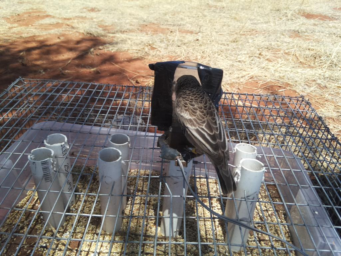

In [8]:
from wildlife_datasets import datasets, analysis, loader, metrics
from wildlife_tools.data import WildlifeDataset, SplitMetadata
import torchvision.transforms as T


d = datasets.BirdIndividualID('data/BirdIndividualID_small')

metadata = d.df
dataset_root = d.root

dataset = WildlifeDataset(metadata, dataset_root, transform=Resize(256))
img, label = dataset[100]
print(label)
img



0: 192x256 1 bird, 4 cups, 1 dining table, 739.7ms
Speed: 1.0ms preprocess, 739.7ms inference, 1.3ms postprocess per image at shape (1, 3, 192, 256)


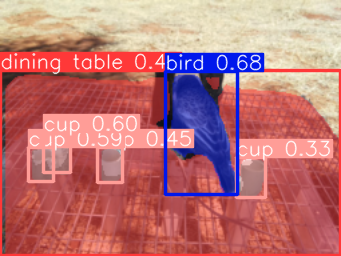

In [9]:
# Test the prediction
model = YOLO('content/yolov8x-seg.pt')

result_predict = model.predict(source = img, imgsz=(256), single_cls=True)

# show results
plot = result_predict[0].plot()
plot = cv2.cvtColor(plot, cv2.COLOR_BGR2RGB)
display(Image.fromarray(plot))


0: 256x224 1 bird, 3144.5ms
Speed: 0.5ms preprocess, 3144.5ms inference, 6.9ms postprocess per image at shape (1, 3, 256, 224)


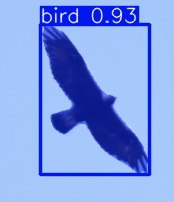

In [10]:
img = Image.open('goleag-ex2.png')
result_predict = model.predict(source = img, imgsz=(256))

# show results
plot = result_predict[0].plot()
plot = cv2.cvtColor(plot, cv2.COLOR_BGR2RGB)
display(Image.fromarray(plot))

By default it'll save to runs/task/predict and the task can be detect/segment/classify(depends on what task you're using). The save path consists of two args -> project/name, and you can modify these two args to customize your save path.
- To save crops you can use save_crop=True

example: 
model = YOLO("model/best.pt")
model.predict(source = '/home/sangramdh/Downloads/rajsir/test_models/test/2 Wheel Test/', show = True, save=True)
cv2.waitKey(0)

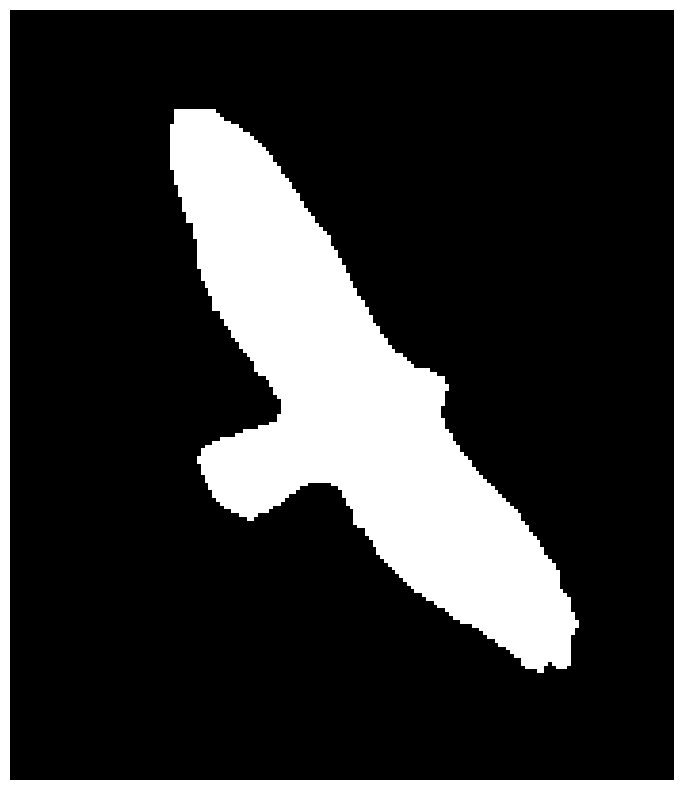

In [15]:
from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Iterate detection results 
for r in result_predict:
    img = np.copy(r.orig_img)
    img_name = Path(r.path).stem

    # Iterate each object contour 
    for ci, c in enumerate(r):
        label = c.names[c.boxes.cls.tolist().pop()]

        b_mask = np.zeros(img.shape[:2], np.uint8) # binary mask

        # Create contour mask 
        contour = c.masks.xy.pop().astype(np.int32).reshape(-1, 1, 2)
        _ = cv2.drawContours(b_mask, [contour], -1, (255, 255, 255), cv2.FILLED)

        # Choose one:

        # OPTION-1: Isolate object with black background
        mask3ch = cv2.cvtColor(b_mask, cv2.COLOR_GRAY2BGR) # apply b_mask into 3 channels
        isolated = cv2.bitwise_and(mask3ch, img) # apply mask to image

        # Display
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(b_mask, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()


In [19]:
import cv2
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt


def get_binary_mask(image_path):
    img = Image.open(image_path)
    result_predict = model.predict(source = img, imgsz=(256))

    for r in result_predict:
        img = np.copy(r.orig_img)

        # Iterate each object contour 
        for c in r:
            label = c.names[c.boxes.cls.tolist().pop()]

            if label == "bird":
                b_mask = np.zeros(img.shape[:2], np.uint8)  # binary mask

                # Create contour mask
                contour = c.masks.xy.pop().astype(np.int32).reshape(-1, 1, 2)
                _ = cv2.drawContours(b_mask, [contour], -1, (255, 255, 255), cv2.FILLED)

                return b_mask  # Return the first bird mask found

    return None  # Return None if no bird is found


def get_bbox_from_mask(mask):
     # Get the bounding box from the binary mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        x, y, w, h = cv2.boundingRect(contours[0])
        return [x, y, w, h]
    else:
        return None  # Return None if no contours are found

def get_segmentation_from_mask(mask):
    # Get the segmentation from the binary mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        segmentation = []
        for contour in contours:
            segmentation.append(contour.flatten().tolist())
        return segmentation
    else:
        return None  # Return None if no contours are found


df = d.df

# Add bbox and segmentation to DataFrame
bbox_list = []
segmentation_list = []

for index, row in df.iterrows():
    image_path =  os.path.join(d.root, row['path'])
    binary_mask = get_binary_mask(image_path)
    
    bbox = get_bbox_from_mask(binary_mask)
    segmentation = get_segmentation_from_mask(binary_mask)
    
    bbox_list.append(bbox)
    segmentation_list.append(segmentation)


df['bbox'] = bbox_list
df['segmentation'] = segmentation_list

# Save DataFrame to a file
df.to_csv('bird_seg_metadata.csv', index=False)

# Display the DataFrame
print(df)



0: 160x256 (no detections), 1381.4ms
Speed: 5.1ms preprocess, 1381.4ms inference, 0.3ms postprocess per image at shape (1, 3, 160, 256)

0: 192x256 1 bird, 646.8ms
Speed: 0.5ms preprocess, 646.8ms inference, 2.9ms postprocess per image at shape (1, 3, 192, 256)

0: 192x256 5 birds, 605.4ms
Speed: 0.4ms preprocess, 605.4ms inference, 2.2ms postprocess per image at shape (1, 3, 192, 256)

0: 160x256 (no detections), 1617.7ms
Speed: 0.6ms preprocess, 1617.7ms inference, 0.3ms postprocess per image at shape (1, 3, 160, 256)

0: 192x256 3 birds, 1 cat, 4 cups, 602.6ms
Speed: 0.6ms preprocess, 602.6ms inference, 1.1ms postprocess per image at shape (1, 3, 192, 256)

0: 192x256 1 bird, 2 cups, 471.8ms
Speed: 0.4ms preprocess, 471.8ms inference, 0.9ms postprocess per image at shape (1, 3, 192, 256)

0: 192x256 2 cups, 639.4ms
Speed: 0.3ms preprocess, 639.4ms inference, 0.7ms postprocess per image at shape (1, 3, 192, 256)

0: 192x256 2 birds, 4 cups, 482.4ms
Speed: 0.5ms preprocess, 482.4ms i

In [31]:
import os
import cv2
import numpy as np
import pandas as pd
import json
from PIL import Image
import matplotlib.pyplot as plt
from pycocotools import mask as mask_coco


def get_rle_from_mask(mask):
    if mask is None:
        return None
    rle = mask_coco.encode(np.asfortranarray(mask))
    rle['counts'] = rle['counts'].decode('utf-8')  # Convert from bytes to string
    return rle

# Load your DataFrame
df = d.df

# Add bbox and segmentation to DataFrame
bbox_list = []
segmentation_list = []

for index, row in df.iterrows():
    image_path =  os.path.join(d.root, row['path'])
    binary_mask = get_binary_mask(image_path)
    
    bbox = get_bbox_from_mask(binary_mask)
    rle_segmentation = get_rle_from_mask(binary_mask)
    
    bbox_list.append(bbox)
    segmentation_list.append(rle_segmentation)

df['bbox'] = bbox_list
df['segmentation'] = segmentation_list

# Save DataFrame to a file
df.to_csv('bird_seg_metadata-1.csv', index=False)

# Display the DataFrame
print(df)



0: 160x256 (no detections), 1530.4ms
Speed: 4.7ms preprocess, 1530.4ms inference, 0.8ms postprocess per image at shape (1, 3, 160, 256)

0: 192x256 1 bird, 685.1ms
Speed: 0.4ms preprocess, 685.1ms inference, 2.4ms postprocess per image at shape (1, 3, 192, 256)

0: 192x256 5 birds, 337.4ms
Speed: 0.4ms preprocess, 337.4ms inference, 1.0ms postprocess per image at shape (1, 3, 192, 256)

0: 160x256 (no detections), 429.7ms
Speed: 0.6ms preprocess, 429.7ms inference, 0.1ms postprocess per image at shape (1, 3, 160, 256)

0: 192x256 3 birds, 1 cat, 4 cups, 388.0ms
Speed: 0.4ms preprocess, 388.0ms inference, 1.0ms postprocess per image at shape (1, 3, 192, 256)

0: 192x256 1 bird, 2 cups, 408.2ms
Speed: 0.4ms preprocess, 408.2ms inference, 0.8ms postprocess per image at shape (1, 3, 192, 256)

0: 192x256 2 cups, 571.8ms
Speed: 0.4ms preprocess, 571.8ms inference, 0.7ms postprocess per image at shape (1, 3, 192, 256)

0: 192x256 2 birds, 4 cups, 441.8ms
Speed: 0.4ms preprocess, 441.8ms inf

In [30]:
import pandas as pd
import numpy as np
import ast
from pycocotools import mask

# Load your CSV data
data = pd.read_csv('bird_seg_metadata.csv')

# Correct the bbox format
data['bbox'] = data['bbox'].apply(lambda x: x.replace('""', '') if pd.notnull(x) else x)

# Function to extract size from the segmentation string
def extract_size(seg):
    if pd.isnull(seg) or seg == "NaN":
        return (None, None)
    else:
        seg_dict = ast.literal_eval(seg.replace('""', ''))
        if isinstance(seg_dict, dict):
            return seg_dict.get('size', (None, None))
        return (None, None)

# Convert segmentation to RLE format
def polygon_to_rle(seg, height, width):
    if pd.isnull(seg) or seg == "NaN" or height is None or width is None:
        return seg
    else:
        seg_dict = ast.literal_eval(seg.replace('""', ''))
        if isinstance(seg_dict, dict) and 'counts' in seg_dict and isinstance(seg_dict['counts'], list):
            rle = mask.frPyObjects([seg_dict['counts']], height, width)
            rle = mask.merge(rle)
            rle['counts'] = rle['counts'].decode('utf-8')  # Decode byte format to string
            return str(rle)
        return seg

# Extract the size and convert the segmentation to RLE format
data['segmentation'] = data.apply(lambda row: polygon_to_rle(row['segmentation'], *extract_size(row['segmentation'])), axis=1)

# Save the corrected data to a new CSV file
data.to_csv('corrected_output_file.csv', index=False)


## 2. Different load regimes

Full image
- Full image 'full'
- Full image with redacted background 'full_mask'
- Full image with redacted foreground 'full_hide'


BBox Cropping
- BBox cropped 'bbox'
- BBox cropped with redacted background 'bbox_mask'
- BBox cropped with redacted foreground 'bbox_hide'

Other
- Cropping black background if there is one 'crop_black'

0


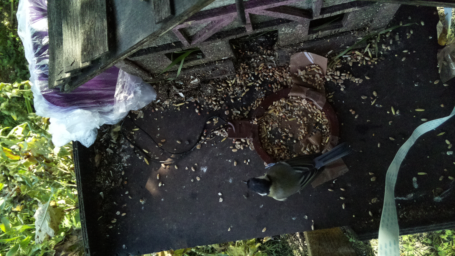

In [38]:
metadata = pd.read_csv('bird_seg_metadata-1.csv')
dataset_root = 'data/BirdIndividualID_small'

dataset = WildlifeDataset(metadata, dataset_root, transform=Resize(256))
img, label = dataset[0]
print(label)
img

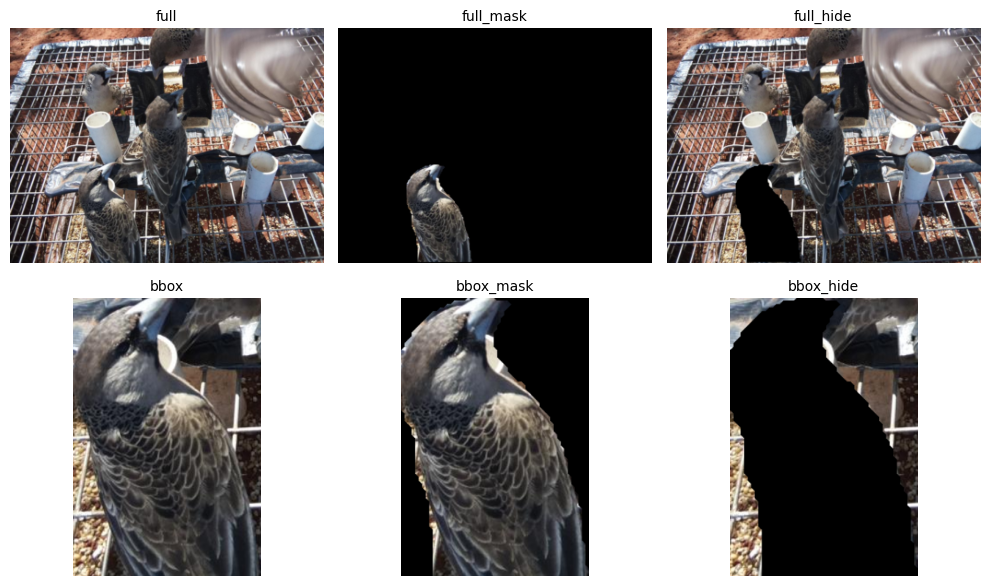

In [43]:
from wildlife_tools.data.dataset import WildlifeDataset
from torchvision.transforms import Resize
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(10, 6))
axes = axes.flatten()

methods = ['full', 'full_mask', 'full_hide', 'bbox', 'bbox_mask', 'bbox_hide']
for i, method in enumerate(methods):
    dataset = WildlifeDataset(metadata, dataset_root, img_load=method, transform=Resize(256))
    img, _ = dataset[4]

    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(method, fontsize=10, pad=5)


plt.tight_layout()
plt.savefig('loading_methods.png')
plt.show()

## 3. Add Transform

In [40]:
from torchvision import transforms as T
transform = T.Compose([
    T.Resize([256, 256]),
    T.ToTensor(),
])
dataset = WildlifeDataset(metadata, root=dataset_root, img_load='full', transform=transform)
img, label = dataset[0]
print(img.shape)
img

torch.Size([3, 256, 256])


tensor([[[0.2039, 0.1882, 0.1882,  ..., 0.0706, 0.0824, 0.0980],
         [0.1686, 0.2275, 0.2745,  ..., 0.0667, 0.0706, 0.0706],
         [0.1216, 0.1725, 0.2157,  ..., 0.0863, 0.0902, 0.0784],
         ...,
         [0.4549, 0.3294, 0.3412,  ..., 0.5922, 0.3686, 0.3216],
         [0.7176, 0.3569, 0.3059,  ..., 0.4471, 0.2745, 0.3059],
         [0.7412, 0.3137, 0.2667,  ..., 0.4118, 0.2431, 0.2039]],

        [[0.2588, 0.2588, 0.2549,  ..., 0.0667, 0.0824, 0.1020],
         [0.2000, 0.2941, 0.3647,  ..., 0.0431, 0.0510, 0.0510],
         [0.1608, 0.2235, 0.2902,  ..., 0.0824, 0.0824, 0.0745],
         ...,
         [0.5765, 0.4353, 0.4353,  ..., 0.6784, 0.4392, 0.3961],
         [0.7882, 0.4627, 0.3961,  ..., 0.5137, 0.3137, 0.3765],
         [0.8118, 0.4039, 0.3216,  ..., 0.4667, 0.2471, 0.2549]],

        [[0.1529, 0.1569, 0.1647,  ..., 0.0667, 0.0706, 0.0824],
         [0.0980, 0.1804, 0.2314,  ..., 0.0549, 0.0588, 0.0549],
         [0.0745, 0.1255, 0.1686,  ..., 0.0863, 0.0824, 0.